## <u> Intro </u>

 This notebook isnt as polished as the other code <br/>
 It is purposly verbose and simple, we can build it into something more complex when/if needed <br/>
 Currently it should be very easy to experiment with adding different numbers of hidden layers into the network <br/>
 Also it will be very easy to edit to change number of nodes/epochs/do cross validation etc etc <br/>

 This is my own edit of Sam's orginal, with tweaks as we go

### <u> Quick run through </u>

 It is a simple MLP model - though I think MLP is probably the most sensible to use (we should ask Mikey if he knows of anything more exotic that would make sense using) <br/>
 I think more complex models would be a waste of time, they may perform slightly better but not sure its worth it - again we should ask Mikey his opinion on that <br/>
 
 It takes in a data set of a given size, and essentially does a multi-output regression <br/>
 Use the nanomei_big_data_generator.py script to create data sets of given sizes - you only need to change the 'data_steps' parameter and then the file names it saves too <br/>
 In this version of the scrip I am using a reduced data set created from 100 'data_steps' in the generator script <br/>
 It runs very fast on my mac  <br/>

Results are plotted at the bottom. 

### <u> What Im worried about </u>

Dont know why I didnt think of this earlier but I think the complex numbers arent being handled properly. <br/>
Need to look into this. <br/>
Fist think I think is just break the complex numbers up into real/imaginary and handle them seperatley <br/>



In [79]:
import pickle
import math
import numpy as np
from scipy.special import jv, yv, jve, yve
import matplotlib.pyplot as plt
import pandas as pd
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold, train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
import tensorflow as tf

In [80]:
#root = '/Users/sam/Documents/Nano-Mei'
root = '/Users/wsb/Library/CloudStorage/OneDrive-SharedLibraries-UniversityofSouthampton/Phase retrieval with neural nets - Documents/nanoparticle Mie scattering project/mie Python code/wsb working'

# Use the with statement to open the file and automatically close it when you're done
#with open("{}/Iperp_data_ReducedSet_100Steps.pickle".format(root), "rb") as file:
with open("{}/Itotal_data3.pickle".format(root), "rb") as file:
    # Load the data from the file
    my_dict = pickle.load(file)

Looking at first few keys  [(1.3, 6e-06), (1.3, 6.080808080808081e-06), (1.3, 6.1616161616161615e-06)] 10000
Checking some values  [3458536.53758101 3063652.07105662 2686525.61566017] 100


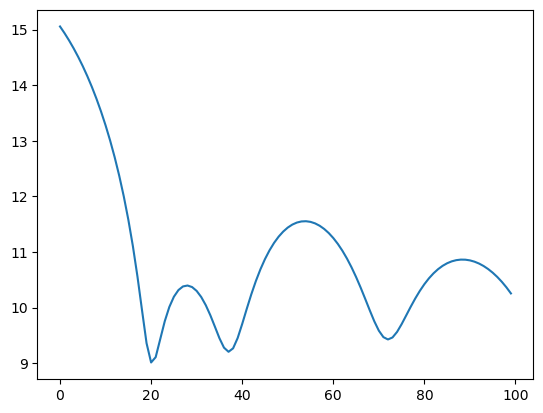

Length of index list is  10000
Size of np_combined_y is  (10000, 2)


In [81]:
# Break apart keys and values from the dictionary 
keys_list = list(my_dict.keys())
values_list = list(my_dict.values())

print('Looking at first few keys ',keys_list[:3], len(keys_list))
foo = values_list[0]
print('Checking some values ',foo[:3], len(foo))
num_theta_values = len(foo)
#try to have a look at the first set of values
plt.figure()
plt.plot(np.log(values_list[0]))
plt.show()

# Break the tuples in keys list into corresponding index and radius values
index = [a for a, _ in keys_list]
radius = [b for _, b in keys_list]
print('Length of index list is ',len(index))

# Ratio for test/train split
#ratio = int(0.8 * len(index))

# Turning lists into numpy arrays 
# could do the scaling right here...
np_index = np.array(index)
np_radius = 1e6 * np.array(radius) #added scaling
np_I = np.array(values_list)

# Recombine index and radius in a more sensible manner
np_combined_y = np.column_stack((np_index,np_radius))
print('Size of np_combined_y is ', np_combined_y.shape)
# Log IPerp
logged_np_I_X = np.log10(np_I)
#Here is where we can shift the data around to set its value to a fixed number at point 1

#this scaling looks WRONG - stop doing it. Instead shift the 
# max_log_I = 10  # this is setting the number I'm scaling to
#for ii in range(logged_np_I_X.shape[0]):
#    foo = logged_np_I_X[ii,:]
#    logged_np_I_X[ii,:] = max_log_I * foo/foo[0]
#take a look:
#fig, ax = plt.subplots()
#ax.plot(logged_np_I_X[23,:])
#plt.show()
#seems to work!! 


# Create test/train splits
# should there be some shuffling here? Otherwise you're fitting out of your data range! None yet as far as I can see - 


#X_train_logI = logged_np_I_X[:ratio]
#Y_train_combinedRI = np_combined_y[:ratio]

#X_test_logI = logged_np_I_X[ratio:]
#Y_test_combinedRI = np_combined_y[ratio:]

#try to write with the scikit function train_test_split
#X_train_logI2, X_test_logI2, Y_train_combinedRI2, Y_test_combinedRI2 = train_test_split(logged_np_I_X, np_combined_y, test_size = 0.2, random_state = 42) 
#print('Shape of compared X_train output arrays are: ', X_train_logI2.shape, X_train_logI2.shape)
#print('Shape of compared X_test output arrays are:  ', X_test_logI2.shape, X_test_logI2.shape)
#print('Shape of compared y_train output arrays are: ', Y_train_combinedRI.shape, Y_train_combinedRI2.shape)
#print('Shape of compared y_test output arrays are:  ', Y_test_combinedRI.shape, Y_test_combinedRI2.shape)

X_train_logI, X_test_logI, Y_train_combinedRI, Y_test_combinedRI = train_test_split(
    logged_np_I_X, np_combined_y, test_size = 0.2, random_state = 42) 

In [82]:
def build_model(input_shape, output_shape):
  # define the model
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Input(shape=input_shape))
  model.add(tf.keras.layers.Dense(64, activation='relu'))
  model.add(tf.keras.layers.Dense(64, activation='relu'))
  model.add(tf.keras.layers.Dense(output_shape))
  #opt = SGD(lr=0.01, momentum=0.9)
  #opt = 'adam'
  model.compile(optimizer='adam', loss='mean_squared_error')
  #model.compile(optimizer=opt, loss='mean_squared_error')
  return model

def train_model(model, num_epochs, X, y):
    #num_epochs = 10
    history = model.fit(X, y, epochs=num_epochs)
    return history

def predict(model, X):
  y_pred = model.predict(X)
  return y_pred

def evaluate(model, X, y):
  y_pred = model.predict(X)
  mse = tf.keras.losses.mean_squared_error(y, y_pred)
  print('The mean squared error:', mse)

def plot_history(history):
  plt.plot(history.history['loss'], label='train')
  #plt.plot(history.history['val_loss'], label='test')
  plt.show()



In [83]:
# build the model
input_shape = (num_theta_values,)
output_shape = 2
model = build_model(input_shape, output_shape)

# train the model
X_train = X_train_logI  # training data, shape (n_samples, 500)
y_train = Y_train_combinedRI  # training labels, shape (n_samples, 2)
num_epochs = 100
history = train_model(model, num_epochs, X_train, y_train)



#save the model:
model.save("Mie_model_v1")

Epoch 1/100
 11/250 [>.............................] - ETA: 1s - loss: 5.2095  

2023-01-26 10:35:46.161384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - 1s 4ms/step - loss: 1.8110
Epoch 2/100
250/250 [==============================] - 1s 4ms/step - loss: 0.8179
Epoch 3/100
250/250 [==============================] - 1s 4ms/step - loss: 0.4792
Epoch 4/100
250/250 [==============================] - 1s 4ms/step - loss: 0.3399
Epoch 5/100
250/250 [==============================] - 1s 4ms/step - loss: 0.2733
Epoch 6/100
250/250 [==============================] - 1s 4ms/step - loss: 0.2474
Epoch 7/100
250/250 [==============================] - 1s 4ms/step - loss: 0.1809
Epoch 8/100
250/250 [==============================] - 1s 4ms/step - loss: 0.1694
Epoch 9/100
250/250 [==============================] - 1s 4ms/step - loss: 0.1406
Epoch 10/100
250/250 [==============================] - 1s 4ms/step - loss: 0.1372
Epoch 11/100
250/250 [==============================] - 1s 4ms/step - loss: 0.1262
Epoch 12/100
250/250 [==============================] - 1s 4ms/step - loss: 0.1119
Epoch 13/100
250/250 [===

63/63 [==============================] - 0s 2ms/step
Shape of the predicted output is  (2000, 2)
63/63 [==============================] - 0s 2ms/step
The mean squared error: tf.Tensor([0.00059768 0.00537673 0.0030617  ... 0.00370782 0.00193287 0.00566346], shape=(2000,), dtype=float32)
dict_keys(['loss'])


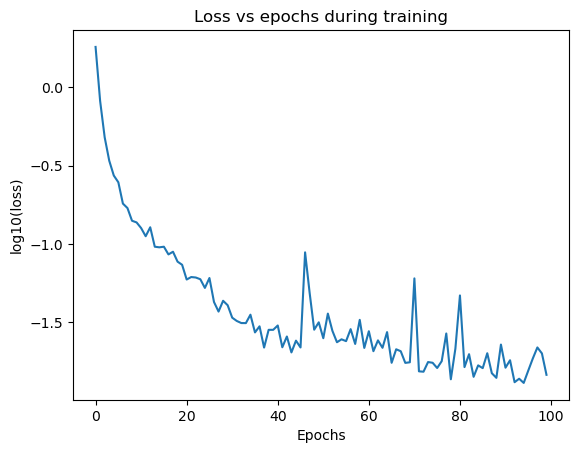

In [92]:
# use the trained model to make predictions
X_test = X_test_logI  # test data, shape (n_samples, 500)

y_pred = predict(model, X_test)
print('Shape of the predicted output is ', y_pred.shape)

# evaluate the model's performance
y_test = Y_test_combinedRI
evaluate(model, X_test, y_test)

print(history.history.keys())

#plot loss
#plot_history(history)
fig, ax = plt.subplots()
ax.plot(np.log10(history.history['loss']), label='train')
ax.set_xlabel('Epochs')
ax.set_ylabel('log10(loss)')
ax.set_title('Loss vs epochs during training')
plt.show()

Checking some values:  [ 1.61313131 10.2020202 ] [ 1.614176 10.236579]


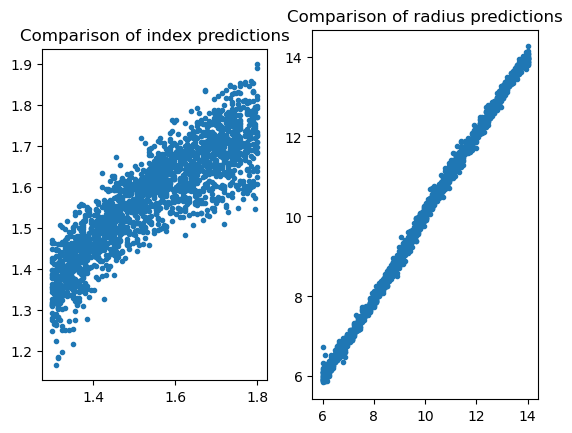

In [85]:
# calculate the difference between the expected and predicted values

#let's just examine these variables...
print('Checking some values: ',y_test[0,:], y_pred[0,:])
difference = y_test - y_pred

# plot the difference
#plt.plot(y_test, label = 'y_test')
#plt.plot(y_pred, label = 'y_pred')
#plt.xlabel('Sample index')
#plt.ylabel('predicted and actual')
#plt.legend()
#plt.show()
# try a plot of one against the other - 
#plt.figure()
fig, ax = plt.subplots(1,2)
ax[0].plot(y_test[:,0], y_pred[:,0],'.')
ax[0].set_aspect('equal','box')
#ax.set(xlim=(1.2,1.8), ylim=(1.2,1.8))
ax[0].set_title('Comparison of index predictions')
#plt.show()
#plt.figure()
ax[1].plot(y_test[:,1], y_pred[:,1],'.')
ax[1].set_title('Comparison of radius predictions')
plt.show()


In [86]:
y_pred

array([[ 1.614176 , 10.236579 ],
       [ 1.6333675, 12.8111925],
       [ 1.4637637,  8.497689 ],
       ...,
       [ 1.6679933, 10.200716 ],
       [ 1.3767834, 13.620419 ],
       [ 1.6416435,  8.2372265]], dtype=float32)

In [87]:
y_test

array([[ 1.61313131, 10.2020202 ],
       [ 1.53232323, 12.78787879],
       [ 1.38585859,  8.50505051],
       ...,
       [ 1.69393939, 10.28282828],
       [ 1.35050505, 13.67676768],
       [ 1.64848485,  8.34343434]])